In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [7]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [8]:
output_size = y_table.shape[0]

In [9]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [10]:
input_shape = x_test_2d_norm[0].shape

In [11]:
def build_2d_cnn_only_conv(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [12]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                780304    
Total params: 780,512
Trainable params: 780,512
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 253, 95, 8)        208      

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36608/36805 [============================>.] - ETA: 0s - loss: 1.5520 - acc: 0.5374
Epoch 00001: val_loss improved from inf to 1.34271, saving model to model/checkpoint/2D_CNN_1_only_conv_checkpoint/01-1.3427.hdf5
36805/36805 [==============================] - 10s 282us/sample - loss: 1.5509 - acc: 0.5378 - val_loss: 1.3427 - val_acc: 0.6215
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1541 - acc: 0.6595
Epoch 00002: val_loss improved from 1.34271 to 1.22821, saving model to model/checkpoint/2D_CNN_1_only_conv_checkpoint/02-1.2282.hdf5
36805/36805 [==============================] - 8s 210us/sample - loss: 1.1540 - acc: 0.6596 - val_loss: 1.2282 - val_acc: 0.6483
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9809 - acc: 0.7097
Epoch 00003: val_loss improved from 1.22821 to 1.13693, saving model to model/checkpoint/2D_

Epoch 28/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.1505 - acc: 0.9675
Epoch 00028: val_loss did not improve from 1.05170
36805/36805 [==============================] - 9s 242us/sample - loss: 0.1504 - acc: 0.9676 - val_loss: 1.4322 - val_acc: 0.7133
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1407 - acc: 0.9711
Epoch 00029: val_loss did not improve from 1.05170
36805/36805 [==============================] - 9s 236us/sample - loss: 0.1408 - acc: 0.9710 - val_loss: 1.4787 - val_acc: 0.7158
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9719
Epoch 00030: val_loss did not improve from 1.05170
36805/36805 [==============================] - 9s 241us/sample - loss: 0.1346 - acc: 0.9719 - val_loss: 1.4729 - val_acc: 0.7209
Epoch 31/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9734
Epoch 00031: val_loss did not improve from 1.05170
36805/36805 [========


1 Only Conv Model


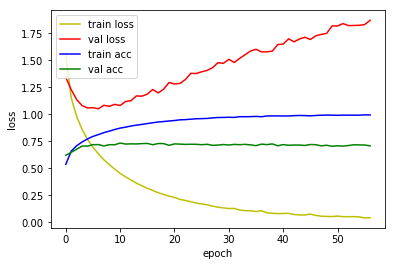

4815/4815 [==============================] - 1s 227us/sample - loss: 1.1397 - acc: 0.6860
Loss: 1.1396899055716652 Accuracy: 0.68598133

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5572 - acc: 0.5329
Epoch 00001: val_loss improved from inf to 1.26359, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/01-1.2636.hdf5
36805/36805 [==============================] - 11s 302us/sample - loss: 1.5571 - acc: 0.5329 - val_loss: 1.2636 - val_acc: 0.6378
Epoch 2/200
36608/36805 [============================>.] - ETA: 0s - loss: 1.1021 - acc: 0.6767
Epoch 00002: val_loss improved from 1.26359 to 1.03339, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/02-1.0334.hdf5
36805/36805 [==============================] - 11s 290us/sample - loss: 1.1024 - acc: 0.6764 - val_loss: 1.0334 - val_acc: 0.7156
Epoch 3/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.8731 - acc: 0.7475
Ep

36672/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9878
Epoch 00027: val_loss did not improve from 0.59692
36805/36805 [==============================] - 10s 279us/sample - loss: 0.0576 - acc: 0.9878 - val_loss: 0.8493 - val_acc: 0.8612
Epoch 28/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9891
Epoch 00028: val_loss did not improve from 0.59692
36805/36805 [==============================] - 11s 286us/sample - loss: 0.0532 - acc: 0.9891 - val_loss: 0.8875 - val_acc: 0.8509
Epoch 29/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9871
Epoch 00029: val_loss did not improve from 0.59692
36805/36805 [==============================] - 11s 287us/sample - loss: 0.0573 - acc: 0.9871 - val_loss: 0.8811 - val_acc: 0.8539
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9907
Epoch 00030: val_loss did not improve from 0.59692
36805/36805 [==================

Epoch 57/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9962
Epoch 00057: val_loss did not improve from 0.59692
36805/36805 [==============================] - 9s 236us/sample - loss: 0.0201 - acc: 0.9962 - val_loss: 1.0892 - val_acc: 0.8595
Epoch 58/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9984
Epoch 00058: val_loss did not improve from 0.59692
36805/36805 [==============================] - 9s 244us/sample - loss: 0.0134 - acc: 0.9984 - val_loss: 1.0609 - val_acc: 0.8626
Epoch 59/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9985
Epoch 00059: val_loss did not improve from 0.59692
36805/36805 [==============================] - 9s 245us/sample - loss: 0.0127 - acc: 0.9985 - val_loss: 1.0794 - val_acc: 0.8602

2 Only Conv Model


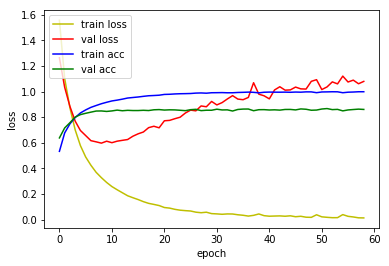

4815/4815 [==============================] - 1s 188us/sample - loss: 0.7259 - acc: 0.8085
Loss: 0.7258918766415874 Accuracy: 0.8085151

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6137 - acc: 0.5090
Epoch 00001: val_loss improved from inf to 1.22759, saving model to model/checkpoint/2D_CNN_3_only_conv_checkpoint/01-1.2276.hdf5
36805/36805 [==============================] - 11s 306us/sample - loss: 1.6136 - acc: 0.5091 - val_loss: 1.2276 - val_acc: 0.6527
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9962 - acc: 0.7144
Epoch 00002: val_loss improved from 1.22759 to 0.86000, saving model to model/checkpoint/2D_CNN_3_only_conv_checkpoint/02-0.8600.hdf5
36805/36805 [==============================] - 11s 289us/sample - loss: 0.9962 - acc: 0.7144 - val_loss: 0.8600 - val_acc: 0.7668
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7268 - acc: 0.7920
Epo

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9771
Epoch 00027: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 277us/sample - loss: 0.0813 - acc: 0.9771 - val_loss: 0.5900 - val_acc: 0.9036
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0732 - acc: 0.9797
Epoch 00028: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 282us/sample - loss: 0.0731 - acc: 0.9798 - val_loss: 0.6236 - val_acc: 0.8987
Epoch 29/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0684 - acc: 0.9809
Epoch 00029: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 280us/sample - loss: 0.0687 - acc: 0.9807 - val_loss: 0.6041 - val_acc: 0.9017
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9816
Epoch 00030: val_loss did not improve from 0.48339
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9939
Epoch 00057: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 282us/sample - loss: 0.0289 - acc: 0.9939 - val_loss: 0.7559 - val_acc: 0.9057
Epoch 58/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9922
Epoch 00058: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 278us/sample - loss: 0.0341 - acc: 0.9921 - val_loss: 0.7631 - val_acc: 0.9043
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9955
Epoch 00059: val_loss did not improve from 0.48339
36805/36805 [==============================] - 10s 280us/sample - loss: 0.0231 - acc: 0.9955 - val_loss: 0.7148 - val_acc: 0.9089
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9973
Epoch 00060: val_loss did not improve from 0.48339
36805/36805 [=====

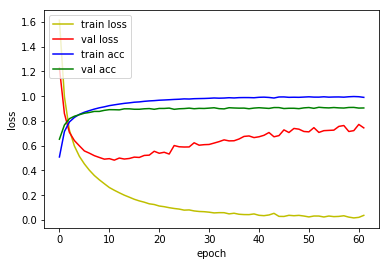

4815/4815 [==============================] - 1s 223us/sample - loss: 0.5494 - acc: 0.8729
Loss: 0.5493663959723519 Accuracy: 0.8728972

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6082 - acc: 0.5114
Epoch 00001: val_loss improved from inf to 1.09899, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/01-1.0990.hdf5
36805/36805 [==============================] - 12s 328us/sample - loss: 1.6080 - acc: 0.5115 - val_loss: 1.0990 - val_acc: 0.6832
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9325 - acc: 0.7323
Epoch 00002: val_loss improved from 1.09899 to 0.78142, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/02-0.7814.hdf5
36805/36805 [==============================] - 11s 302us/sample - loss: 0.9324 - acc: 0.7323 - val_loss: 0.7814 - val_acc: 0.7883
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7186 - acc: 0.7972
Epo

Epoch 27/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9679
Epoch 00027: val_loss did not improve from 0.40783
36805/36805 [==============================] - 11s 292us/sample - loss: 0.1071 - acc: 0.9679 - val_loss: 0.5115 - val_acc: 0.9124
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9699
Epoch 00028: val_loss did not improve from 0.40783
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0981 - acc: 0.9700 - val_loss: 0.4787 - val_acc: 0.9168
Epoch 29/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9719
Epoch 00029: val_loss did not improve from 0.40783
36805/36805 [==============================] - 10s 283us/sample - loss: 0.0938 - acc: 0.9719 - val_loss: 0.5607 - val_acc: 0.9082
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9720
Epoch 00030: val_loss did not improve from 0.40783
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9877
Epoch 00057: val_loss did not improve from 0.40783
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0440 - acc: 0.9877 - val_loss: 0.6313 - val_acc: 0.9166
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9919
Epoch 00058: val_loss did not improve from 0.40783
36805/36805 [==============================] - 11s 298us/sample - loss: 0.0312 - acc: 0.9919 - val_loss: 0.6382 - val_acc: 0.9201
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9897
Epoch 00059: val_loss did not improve from 0.40783
36805/36805 [==============================] - 11s 293us/sample - loss: 0.0384 - acc: 0.9897 - val_loss: 0.6674 - val_acc: 0.9168
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9868
Epoch 00060: val_loss did not improve from 0.40783
36805/36805 [=====

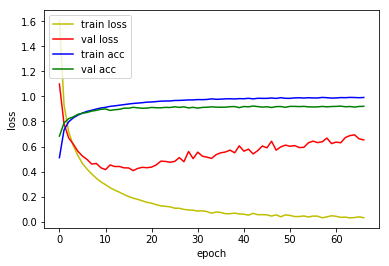

4815/4815 [==============================] - 1s 239us/sample - loss: 0.5046 - acc: 0.8766
Loss: 0.5046394329761791 Accuracy: 0.8766355



In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv'.format(i)
    model = build_2d_cnn_only_conv(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                780304    
Total params: 780,512
Trainable params: 780,512
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 217us/sample - loss: 1.1397 - acc: 0.6860
Loss: 1.1396899055716652 Accuracy: 0.68598133

2D_CNN_2_only_conv Model
_________________________________________________________________
Layer (type)  